# DM2 COMPILED VERSION
### Habiba Hmamed 22323426
### Philippe Hinault 22006949

### Useful Imports

In [1]:
import boto3
from botocore import UNSIGNED
from botocore.client import Config

import os
import pandas as pd
from pyspark.sql import SparkSession
import pyarrow as pa
import pyarrow.parquet as pq
import zipfile
from pyspark.sql.functions import lit

from pyspark.sql.functions import col, to_timestamp, udf, count, when, isnull, year, dayofweek, mean, hour, concat
from pyspark.sql.types import StringType
import shutil
import tempfile



import matplotlib.pyplot as plt


### Directories locations

In [2]:
csv_directory = './data'
parquet_directory = './parquet_data'
temp_parquet_dir = './temp_parquet_data'

### Program for fetching the data 

In [3]:
def get_s3_data(bucket, start_year, end_year):
    #create the s3 client and assign credentials (UNSIGEND for public 
                     
    client = boto3.client('s3', config=Config(signature_version=UNSIGNED))
    years_list = [str(x) for x in list(range(start_year, end_year +1))]
    #create a list of 'Contect' objects from the s3 bucket
    list_files = client.list_objects(Bucket=bucket)['Contents']

    if not os.path.exists('./data'):
        os.makedirs('./data')

    for key in list_files:
        
        if key['Key'].endswith('.zip') and key['Key'][0:4] in years_list :
            if os.path.exists(f'./data/{key["Key"]}'):
                print (f'{key["Key"]} already exists')
            else :
                print(f'downloading... {key["Key"]}') #print file name
                client.download_file(
                                        Bucket=bucket, #assign bucket name
                                        Key=key['Key'], #key is the file name
                                        Filename=os.path.join('./data', 
                                            key['Key']) #storage file path
                                )
        else:
            pass #if it's not a zip file do nothing

### Dataframes schemas
Two schema for the two standards in the data. Later unified into one (schema_type_three)

In [4]:
start_year = 2014
end_year = 2023

tmp = "./tmp"
csv_directory = './data'
parquet_directory = './parquet_data'
temp_parquet_dir = './temp_parquet_data'

schema_type_standard_one = [
    "tripduration",
    "start_time", 
    "stop_time", 
    "start_station_id", 
    "start_station_name", 
    "start_station_latitude", 
    "start_station_longitude", 
    "end_station_id", 
    "end_station_name", 
    "end_station_latitude", 
    "end_station_longitude", 
    "bikeid", 
    "user_type", 
    "birth_year",
    "gender",
]

schema_type_standard_two = [
    "ride_id",
    "rideable_type",
    "start_time",
    "stop_time",
    "start_station_name",
    "start_station_id",
    "end_station_name",
    "end_station_id",
    "start_station_latitude",
    "start_station_longitude",
    "end_station_latitude",
    "end_station_longitude",
    "user_type",
]

schema_type_union_standard = {
    "ride_id": "string",
    "rideable_type": "string",
    "start_time": "timestamp",
    "stop_time": "timestamp",
    "start_station_id": "float",
    "start_station_name": "string",
    "start_station_latitude": "double",
    "start_station_longitude": "double",
    "end_station_id": "float",
    "end_station_name": "string",
    "end_station_latitude": "double",
    "end_station_longitude": "double",
    "bikeid": "float",
    "user_type": "string",
    "birth_year": "integer",
    "gender": "string"
}


### Starting the Session

In [5]:
spark = SparkSession.builder \
        .appName("CSVtoParquet") \
        .config("spark.executor.memory", "8g") \
        .config("spark.driver.memory", "8g") \
        .config("spark.executor.cores", "4") \
        .config("spark.driver.cores", "4") \
        .config("spark.sql.shuffle.partitions", "8") \
        .config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
        .getOrCreate()


24/06/04 22:49:47 WARN Utils: Your hostname, leepleep resolves to a loopback address: 127.0.1.1; using 192.168.0.27 instead (on interface wlp3s0)
24/06/04 22:49:47 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


## Basic Library for conversion
### to convert the csv content and turn it to the new standard, which is the two standard merged and renamed 

Important note: "member" is seemingly the new name for "Subscriber" in "user_type", it is kept unchanged because Subscriber has more informations in the old standard
including: birth_year, gender.
All IDs are floats, because there were IDs like "XXX.04" in the second standard. It is unsure if the others will be integers in the future 


In [6]:
# One of the best ways to differientiate between the two schemas is by the number of columns they have
standard_one_format = 15
standard_two_format = 13

date_format_one = 'M/d/yyyy HH:mm:ss'
date_format_two = 'yyyy-MM-dd HH:mm:ss'
date_format_three = 'M/d/yyyy HH:mm'


def extract_zip_if_needed(zip_path, extract_dir):
    if not os.path.exists(extract_dir) or not os.listdir(extract_dir):
        print(f"Extracting zip file: {zip_path} to directory: {extract_dir}")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
        print("Extraction complete.")
    else:
        print(f"Directory {extract_dir} already exists and is not empty. Skipping extraction.")

def read_csv_to_df(csv_path, year):
    try:
        print(f"Reading CSV file: {csv_path}")
        sdf = spark.read.option("header", "true").csv(csv_path)
        num_partitions = sdf.rdd.getNumPartitions()
        print(f"Number of partitions: {num_partitions}")
        storage_level = sdf.storageLevel
        print(f"Storage Level: {storage_level}")
        # Perform necessary data cleaning
        sdf = clean_sdf_data(sdf, year)
        sdf.show(3, truncate=False)
        print(sdf.dtypes)
        print(f"CSV file {csv_path} successfully read into DataFrame.")
        return sdf
    except Exception as e:
        print(f"Error reading CSV file: {csv_path}. Error: {e}")
        return None

def find_all_csv_files(directory):
    csv_files = []
    for root, dirs, files in os.walk(directory):
        # Ignore directories containing "__MACOSX"
        dirs[:] = [d for d in dirs if '__MACOSX' not in d]
        for file in files:
            # Ignore files starting with "._"
            if file.endswith('.csv') and not file.startswith('._'):
                csv_files.append(os.path.join(root, file))
    return csv_files


def convert_from_csv(year, csv_dir, temp_parquet_dir ,cleanup=True):
    print(f"Looking for zip files in directory: {csv_dir} for year: {year}")
    zip_name = [f for f in os.listdir(csv_dir) if f.startswith(str(year))][0]
    zip_path = os.path.join(csv_dir, zip_name)
    
    temp_dir = os.path.join(csv_dir, f"temp_extract_{year}")
    os.makedirs(temp_dir, exist_ok=True)
    print(f"Created temporary directory: {temp_dir}")
    result = []
    try:
        extract_zip_if_needed(zip_path, temp_dir)
        
        csv_files = find_all_csv_files(temp_dir)

        for csv_file in csv_files:
            print(f"Processing CSV file: {csv_file}")
            sdf = read_csv_to_df(csv_file, year)
            if sdf is not None:
                result.append(sdf)
                print(f"CSV file {csv_file} successfully added to result list.")

        union_all_sdf(result, year, temp_parquet_dir)

    except Exception as e:
        print(f"Error processing ZIP file: {zip_path}. Error: {e}")
    finally:
        if cleanup:
            print(f"Deleting temporary directory: {temp_dir}")
            shutil.rmtree(temp_dir)
            print("Temporary directory deleted.")
        else:
            print(f"Temporary directory left : {temp_dir}, only use this if you want to inspect the files.")
    return result


def convert_gender(string_value):
        Male = "M"
        Female = "F"
            
        if string_value == "1":
                return Male
        elif string_value == "2":
                return Female
        else:
                return "Unknown"
        
def reorder_columns(sdf, schema_order):
    new_order = []

    # Reorder the columns according to the schema order
    for column in schema_order:
        if column in sdf.columns:
            new_order.append(column)

    # Select the columns in the new order
    sdf = sdf.select(*new_order)

    # Cast the columns to the specified types using the schema
    for column in new_order:
        col_type = schema_type_union_standard.get(column)
        if col_type:
            sdf = sdf.withColumn(column, sdf[column].cast(col_type))
    
    return sdf

def add_missing_columns(sdf):
       # add missing colums from the standard schema union
        for col in schema_type_union_standard:
                if col not in sdf.columns:
                        sdf = sdf.withColumn(col, lit("Unknown").cast("string"))
        return sdf

def convert_date_column(df, date_col):
    # Try to convert the date column to timestamp using the first format
    temp_col_one = to_timestamp(col(date_col), date_format_one)
    
    # If conversion with the first format fails, try with the third format
    temp_col_three = when(isnull(temp_col_one), to_timestamp(col(date_col), date_format_three)).otherwise(temp_col_one)
    
    # If conversion with the third format fails, it's the second format
    parsed_col = when(isnull(temp_col_three), to_timestamp(col(date_col), date_format_two)).otherwise(temp_col_three)
    
    # Convert to the unified format (date_format_two)
    final_col = to_timestamp(parsed_col, date_format_two)
    
    # Replace the original column with the new one
    df = df.withColumn(date_col, final_col)

    return df

def change_user_type(user_type):
    if user_type == "Customer":
        return "member"
    elif user_type == "Subscriber":
        return "Subscriber"
    else:
        return "Unknown"

def clean_sdf_first_standard (sdf, year):
        # rename the column with the standard schema one
        sdf = sdf.toDF(*schema_type_standard_one)

        # drop the tripduration column
        # because of redundancy and the other standard does not have it
        # better to calculate it later if needed
        sdf = sdf.drop("tripduration")

        
        # add missing colums from the standard schema union
        sdf = add_missing_columns(sdf)

        timestamp_cols = [col for col in sdf.columns if 'date' in col or 'time' in col]

        # convert timestamp columns that were str to timestamp type
        for col_ in timestamp_cols:
                if isinstance(sdf.schema[col_].dataType, StringType):
                        sdf = convert_date_column(sdf, col_)
                
                        
        # convert int to gender 
        # 0 is Unknown
        # 1 is Male
        # 2 is Female 
        convert_gender_udf = udf(convert_gender, StringType())

        sdf = sdf.withColumn("gender", convert_gender_udf("gender"))

        # change subcriber to member
        # change customer to casual
        change_user_type_udf = udf(change_user_type, StringType())
        sdf = sdf.withColumn("user_type", change_user_type_udf("user_type"))
        
        # reorder the columns to match the standard schema union
        sdf = reorder_columns(sdf, schema_type_union_standard)

        return sdf

def clean_sdf_second_standard (sdf):
        # rename the column with the standard schema two
        sdf = sdf.toDF(*schema_type_standard_two)

        # add missing colums from the standard schema union
        sdf = add_missing_columns(sdf)

        # reorder the columns to match the standard schema union
        sdf = reorder_columns(sdf, schema_type_union_standard)
        
        return sdf


def clean_sdf_data (sdf, year):
        if len (sdf.columns) == standard_one_format:
                return clean_sdf_first_standard(sdf, year)
        elif len(sdf.columns) == standard_two_format:
                return clean_sdf_second_standard(sdf)

        return sdf

# union every df in a list of dataframes
def union_list_sdf(list_sdf):
    res = None
    for sdf in list_sdf:
        if res is None:
            res = sdf
        else:
            res = res.union(sdf)
    return res

# make a parquet for every year in the range
# all respecting a specific schema
def union_all_sdf (sdf, year, temp_dir):
        print(f"Processing year: {year} for saving to Parquet.")
        sdf = union_list_sdf(sdf)
        save_df_to_parquet(sdf, temp_dir, f"year_{year}")
        print(f"Year {year} successfully saved to parquet in {temp_dir} directory.")
        

def save_df_to_parquet(df, parquet_dir, name):
        if not os.path.exists(parquet_dir):
                os.makedirs(parquet_dir)
        
        parquet_file = os.path.join(parquet_dir, name + '.parquet')
                    
        # Save DataFrame as Parquet
        print("===============Writing to: " + parquet_file)
        df.withColumn("year", year("start_time")).write.partitionBy("year").parquet(parquet_file, mode='overwrite')
        print("===============Ok, just written. Now go look plz: " + parquet_file)
        time.sleep(10)

def find_all_parquet_files(directory):
    parquet_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.parquet'):
                parquet_files.append(os.path.join(root, file))
    return parquet_files

import time
def find_all_parquet_dirs(directory):
    parquet_dirs = []
    print("=======The dir: " + directory)
    time.sleep(20)
    for item in os.listdir(directory):
        print("Found year parquet: " + item)
        item_path = os.path.join(directory, item)
        parquet_dirs.append(item_path)
    return parquet_dirs

def csv_to_parquet (start_year, end_year, csv_dir, parquet_dir, name, cleanup=True):
    # Create a temporary directory to store intermediate Parquet files
    temp_parquet_dir = os.path.join(csv_dir, 'temp_parquet_dir')

    if not os.path.exists(temp_parquet_dir):
        os.makedirs(temp_parquet_dir)

    try:
        # Process each year and save intermediate Parquet files
        # union_all_sdf(start_year, end_year, csv_dir, temp_parquet_dir, cleanup)
        for year in range(start_year, end_year + 1):
            convert_from_csv(year, csv_dir, temp_parquet_dir, cleanup)

        # Find all intermediate Parquet files
        parquet_files = find_all_parquet_dirs(temp_parquet_dir)

        # Read all Parquet files and union them into a single DataFrame
        if len(parquet_files) > 0:
            res = None
            for file in parquet_files:
                print(f"Reading Parquet file: {file}")
                df = spark.read.parquet(file)
                if res is None:
                    res = df
                else:
                    res = res.union(df)
                    print(f"Parquet file {file} successfully read.")
            # Save the final DataFrame as a single Parquet file
            save_df_to_parquet(res, parquet_dir, name)
            print(f"Final Parquet file saved to {parquet_dir}/{name}.parquet")
        else:
            print("No Parquet files found to union.")
    except Exception as e:
        print(f"Error during processing: {e}")
    finally:
        # Cleanup temporary directory if specified
        if cleanup:
            shutil.rmtree(temp_parquet_dir)
            print(f"Temporary directory {temp_parquet_dir} has been removed.")
        
def get_unified_parquet (parquet_dir, name, start_year=2014, end_year=2023):
    print(f"Looking for directory: {parquet_dir}")
    if not os.path.exists(parquet_dir):
        print(f"Directory {parquet_dir} does not exist. \nCreating directory: {parquet_dir}")
        os.makedirs(parquet_dir)

    print(f"Looking for Parquet files in directory: {parquet_dir}")
    fml = parquet_dir + "/" + name + ".parquet"
    print(f"Looking for file: {fml}")
    if os.path.exists(fml):
        print(f"Found {fml} Parquet files in directory: {parquet_dir}")
        df = spark.read.parquet(fml)
        return df
        
    print(f"Parquet file {name} not found.")
    print("Checking and downloading the data from S3")
    get_s3_data('tripdata', start_year, end_year)
    csv_to_parquet(start_year, end_year, csv_directory, parquet_dir, name)

    fml = parquet_dir + "/" + name + ".parquet"
    df = spark.read.parquet(fml)
    return df

# returns unique values of a column
def get_unique_values(df, column_name):
    return df.select(column_name).distinct().collect()

# returns repeated values of a column
def get_repeated_rows(df, column_name):
    # Find the values that are repeated
    repeated_values = df.groupBy(column_name).agg(count(column_name).alias("count")) \
                        .filter(col("count") > 1) \
                        .select(column_name)
    
    # join the repeated values with the original dataframe
    result_df = df.join(repeated_values, on=column_name, how="inner")
    return result_df

## Fetching the dataframe in the unified parquet

Storage Management: csv_to_parquet extract a year in a temporary directory ({year}.parquet), and save it in parquet in an another directory (temp_parquet_data). Then the extracted directory is deleted and the program move to the next year. When every year is done, they are merged into unified.parquet. Every {year}.parquet is then deleted.

note: Please use the commented lines instead in case of failure of get_unified_parquet. 


In [ ]:
# same command if the parquet exists
# sdf = spark.read.parquet("./parquet_data/unified.parquet")
sdf = get_unified_parquet(parquet_directory, "unified")



# get_s3_data('tripdata', start_year, end_year)
# csv_to_parquet(start_year, end_year, csv_directory, parquet_directory, "unified", True)
# sdf = get_unified_parquet(parquet_directory, "unified")


In [ ]:
spark.stop()

## Questions

In [ ]:


sdf = get_unified_parquet(tmp, "unified2", 2014, 2014)


### 1. What is the StorageLevel of the dataframe after reading the csv files ? 
According to df.storagelevel : Serialized 1x Replicated
(same result between "after reading csv" and "after reading parquet file")

In [ ]:
storage_level = sdf.storageLevel
print(f"AFTER CSV Storage Level: {storage_level}")

### 2. What is the number of partition of the dataframe ? 
According to df.rdd.getNumPartitions(): 8 reading the csv

In [ ]:
num_partitions = sdf.rdd.getNumPartitions()
print(f"Number of partitions: {num_partitions}")

### 3. Is it possible to tune this number at loading time ? 
Yes, when you start a SparkSession (.config("spark.sql.shuffle.partitions", "8")) 
or when a dataframe is read (read.option("header", "true").csv(csv_path).repartition(num_partitions))

### 4. Why would we want to modify the number of partition when creating the parquet file ? 
To get faster, if we partition on the year, a column that is frequently used. It could be useful.

## Graphs
note: for performance issues, we mainly used a parquet that had data between 2018 and 2022

In [ ]:
sdf = get_unified_parquet(parquet_directory, "unified")

In [7]:
sdf = get_unified_parquet(tmp, "unified2", 2019, 2021)

Looking for directory: ./tmp
Looking for Parquet files in directory: ./tmp
Looking for file: ./tmp/unified2.parquet
Found ./tmp/unified2.parquet Parquet files in directory: ./tmp


24/06/04 22:50:06 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


### Explain function
the optimized logical plan is shorter than the analysed logical plan in its plan

In [9]:
sdf_explain = get_unified_parquet(tmp, "unified2", 2019, 2021)
sdf_explain = sdf_explain.withColumn("day_of_week", dayofweek(sdf_explain["start_time"])).select("day_of_week").groupBy("day_of_week").count().explain(True)

Looking for directory: ./tmp
Looking for Parquet files in directory: ./tmp
Looking for file: ./tmp/unified2.parquet
Found ./tmp/unified2.parquet Parquet files in directory: ./tmp
== Parsed Logical Plan ==
'Aggregate ['day_of_week], ['day_of_week, count(1) AS count#91L]
+- Project [day_of_week#68]
   +- Project [ride_id#34, rideable_type#35, start_time#36, stop_time#37, start_station_id#38, start_station_name#39, start_station_latitude#40, start_station_longitude#41, end_station_id#42, end_station_name#43, end_station_latitude#44, end_station_longitude#45, bikeid#46, user_type#47, birth_year#48, gender#49, year#50, dayofweek(cast(start_time#36 as date)) AS day_of_week#68]
      +- Relation [ride_id#34,rideable_type#35,start_time#36,stop_time#37,start_station_id#38,start_station_name#39,start_station_latitude#40,start_station_longitude#41,end_station_id#42,end_station_name#43,end_station_latitude#44,end_station_longitude#45,bikeid#46,user_type#47,birth_year#48,gender#49,year#50] parquet


In [10]:
sdf.show(5)

+----------------+-------------+-------------------+-------------------+----------------+--------------------+----------------------+-----------------------+--------------+--------------------+--------------------+---------------------+------+---------+----------+-------+----+
|         ride_id|rideable_type|         start_time|          stop_time|start_station_id|  start_station_name|start_station_latitude|start_station_longitude|end_station_id|    end_station_name|end_station_latitude|end_station_longitude|bikeid|user_type|birth_year| gender|year|
+----------------+-------------+-------------------+-------------------+----------------+--------------------+----------------------+-----------------------+--------------+--------------------+--------------------+---------------------+------+---------+----------+-------+----+
|F4CDEE6B1B4BACFA| classic_bike|2021-09-25 18:22:12|2021-09-25 18:31:42|         7623.13|Riverside Dr & W ...|            40.8013434|         -73.9711457439|        7

/tmp/ipykernel_69379/3826016216.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(couple_station_pd["start_station_name"], rotation=90)
/tmp/ipykernel_69379/3826016216.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(couple_station_pd["start_station_name"], rotation=90)


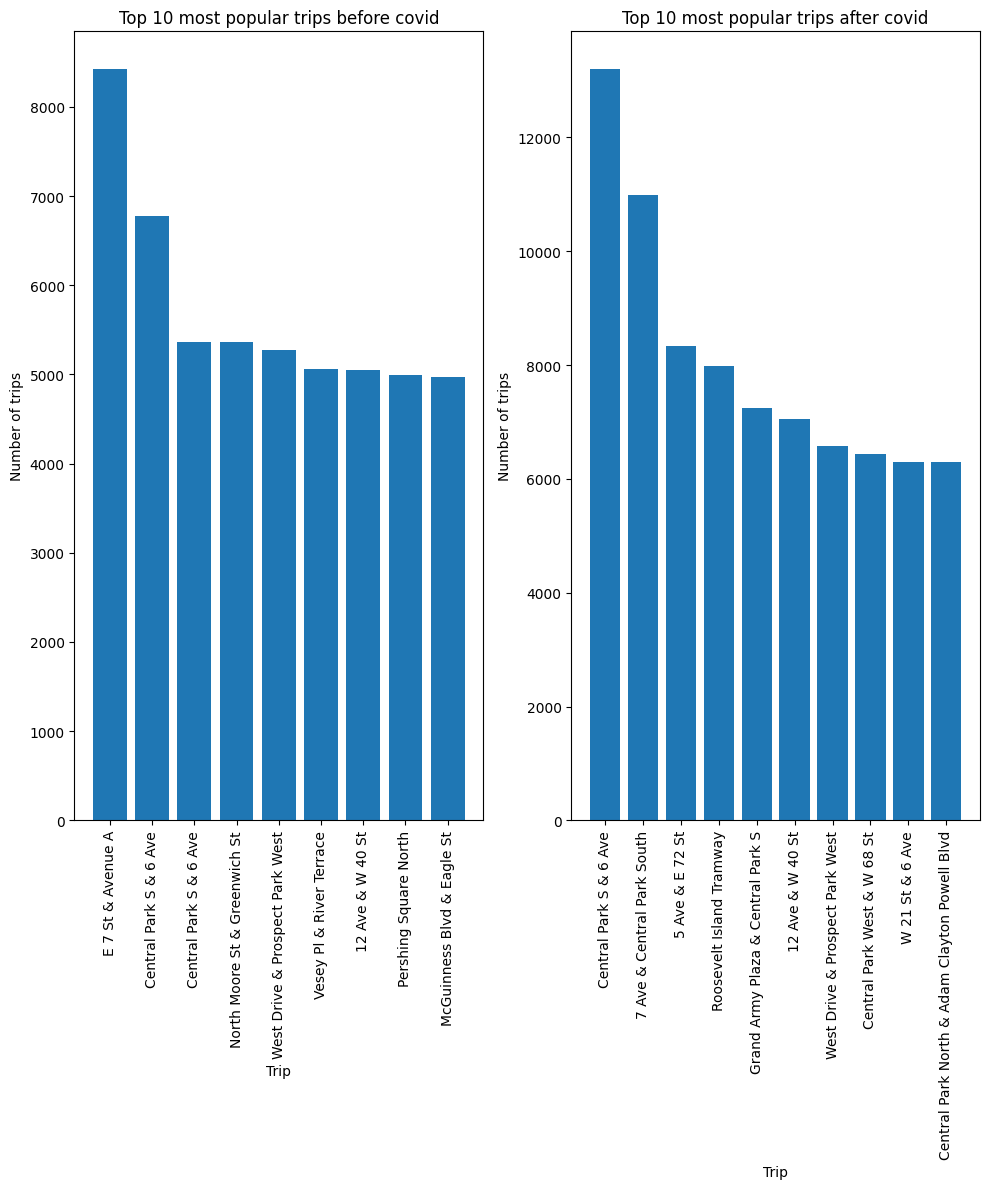

In [11]:


# Count the number of trips for each pickup/dropoff station

def cut_relevant_trip(year_n):
    couple_station = sdf.where(year("start_time") == year_n).groupBy("start_station_name", "end_station_name").count()
    couple_station = couple_station.withColumnRenamed("count", "number_of_trips")
    couple_station = couple_station.orderBy(col("number_of_trips").desc())
    return couple_station

a_year_before_covid = 2019
a_year_after_covid = 2021

couple_station2019 = cut_relevant_trip(a_year_before_covid)
couple_station2021 = cut_relevant_trip(a_year_after_covid)

fig, axs = plt.subplots(1, 2, figsize=(10,12))

# Plot the top 10 most popular trips
couple_station_pd = couple_station2019.toPandas()
couple_station_pd = couple_station_pd.head(10)
axs[0].bar(couple_station_pd["start_station_name"], couple_station_pd["number_of_trips"])
axs[0].set_xlabel('Trip')
axs[0].set_ylabel('Number of trips')
axs[0].set_title('Top 10 most popular trips before covid')
axs[0].set_xticklabels(couple_station_pd["start_station_name"], rotation=90)
couple_station_pd = couple_station2021.toPandas()
couple_station_pd = couple_station_pd.head(10)
axs[1].bar(couple_station_pd["start_station_name"], couple_station_pd["number_of_trips"])
axs[1].set_xlabel('Trip')
axs[1].set_ylabel('Number of trips')
axs[1].set_title('Top 10 most popular trips after covid')
axs[1].set_xticklabels(couple_station_pd["start_station_name"], rotation=90)

plt.tight_layout()
plt.show()



### Conclusions from the trips:
The couples of trips in the top 10 are not the same. But the overall, the couples of trip after are way more frequented. 
The density of cyclists in certain places could be greater.


In [10]:
import math
# Break down the trip distance distribution for each day of the week

def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0

    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi / 2.0)**2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda / 2.0)**2
    c = 2.0 * math.atan2(math.sqrt(a), math.sqrt(1.0 - a))

    distance = R * c

    return distance

def replace_lat_long_with_distance(df):
    haversine_udf = udf(haversine)
    df = df \
        .where(col("start_station_latitude").isNotNull()) \
        .where(col("start_station_longitude").isNotNull()) \
        .where(col("end_station_latitude").isNotNull()) \
        .where(col("end_station_latitude").isNotNull()) \
        .withColumn("distance", haversine_udf("start_station_latitude", "start_station_longitude", "end_station_latitude", "end_station_longitude"))
    return df

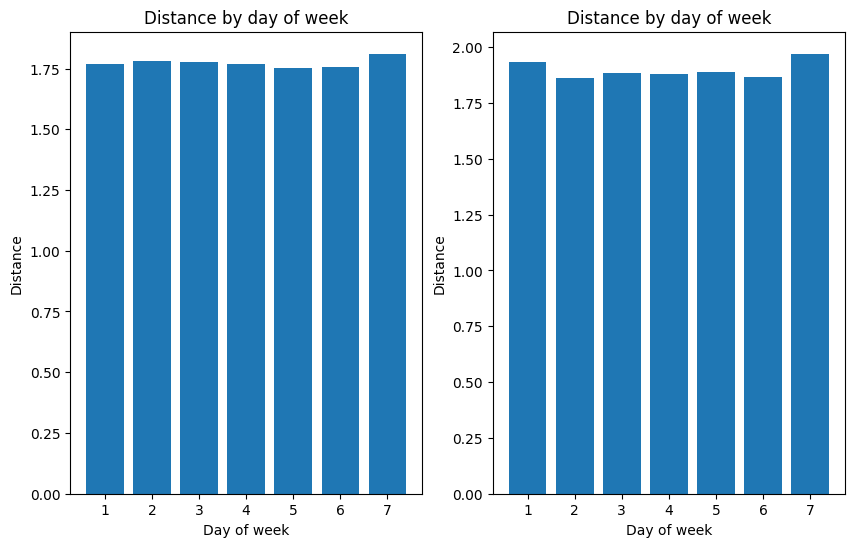

In [11]:


def convert_timestamp_to_day_of_week(df):
    df = df.withColumn("day_of_week", dayofweek(df["start_time"]))

    return df



df = replace_lat_long_with_distance(sdf)
df = convert_timestamp_to_day_of_week(df)


distance_pd2019 = df.where(year("start_time") == 2019).select("day_of_week", "distance").groupBy("day_of_week").agg(mean("distance").alias("distance")).toPandas()
distance_pd2021 = df.where(year("start_time") == 2021).select("day_of_week", "distance").groupBy("day_of_week").agg(mean("distance").alias("distance")).toPandas()

fig, axs = plt.subplots(1, 2, figsize=(10,6))
axs[0].bar(distance_pd2019["day_of_week"], distance_pd2019["distance"])
axs[0].set_xlabel('Day of week')
axs[0].set_ylabel('Distance')
axs[0].set_title('Distance by day of week')
axs[1].bar(distance_pd2021["day_of_week"], distance_pd2021["distance"])
axs[1].set_xlabel('Day of week')
axs[1].set_ylabel('Distance')
axs[1].set_title('Distance by day of week')
plt.show()

### Conclusion from trip distance distribution for each day of the week
the distance is negligeable between each day of the week, with a slight peek after the covid on sunday and saturday. (if we consider the first day is sunday)
but overall, after the covid the distance increased. The distance is done by calculating the flight time (which is wrong, but we should focus on the proportions)

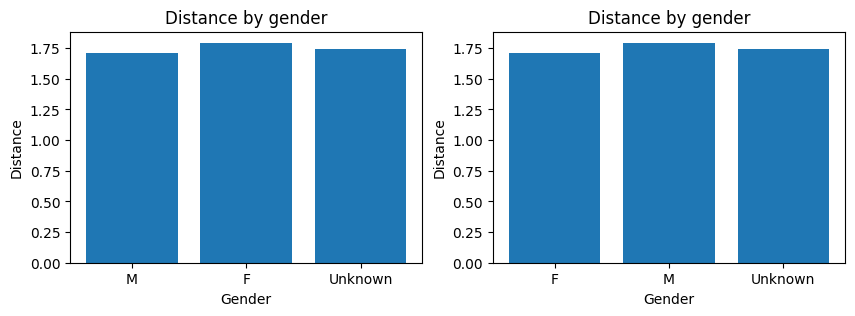

In [14]:
# Trip distance distribution for gender
# gender is only available for the first schema, where there is "Subscriber"
def cut_to_available_Subscriber (df):
    df = df.where(col("user_type") == "Subscriber")
    return df

df = replace_lat_long_with_distance(sdf)
df = cut_to_available_Subscriber(df)
df = df.select("gender", "distance")

gender_pd2019 = df.where(year("start_time") == 2019).groupBy("gender").agg(mean("distance").alias("distance")).toPandas()
gender_pd2021 = df.where(year("start_time") == 2021).groupBy("gender").agg(mean("distance").alias("distance")).toPandas()

figs, axs = plt.subplots(1, 2, figsize=(10,3))
axs[0].bar(gender_pd2019["gender"], gender_pd2019["distance"])
axs[0].set_xlabel('Gender')
axs[0].set_ylabel('Distance')
axs[0].set_title('Distance by gender')
axs[1].bar(gender_pd2021["gender"], gender_pd2019["distance"])
axs[1].set_xlabel('Gender')
axs[1].set_ylabel('Distance')
axs[1].set_title('Distance by gender')
plt.show()


### Conclusions from trip distance for gender
Women tend do to more distance than men and people that did not specify their gender. This plot was made with the subscriber, where they can specify their gender.

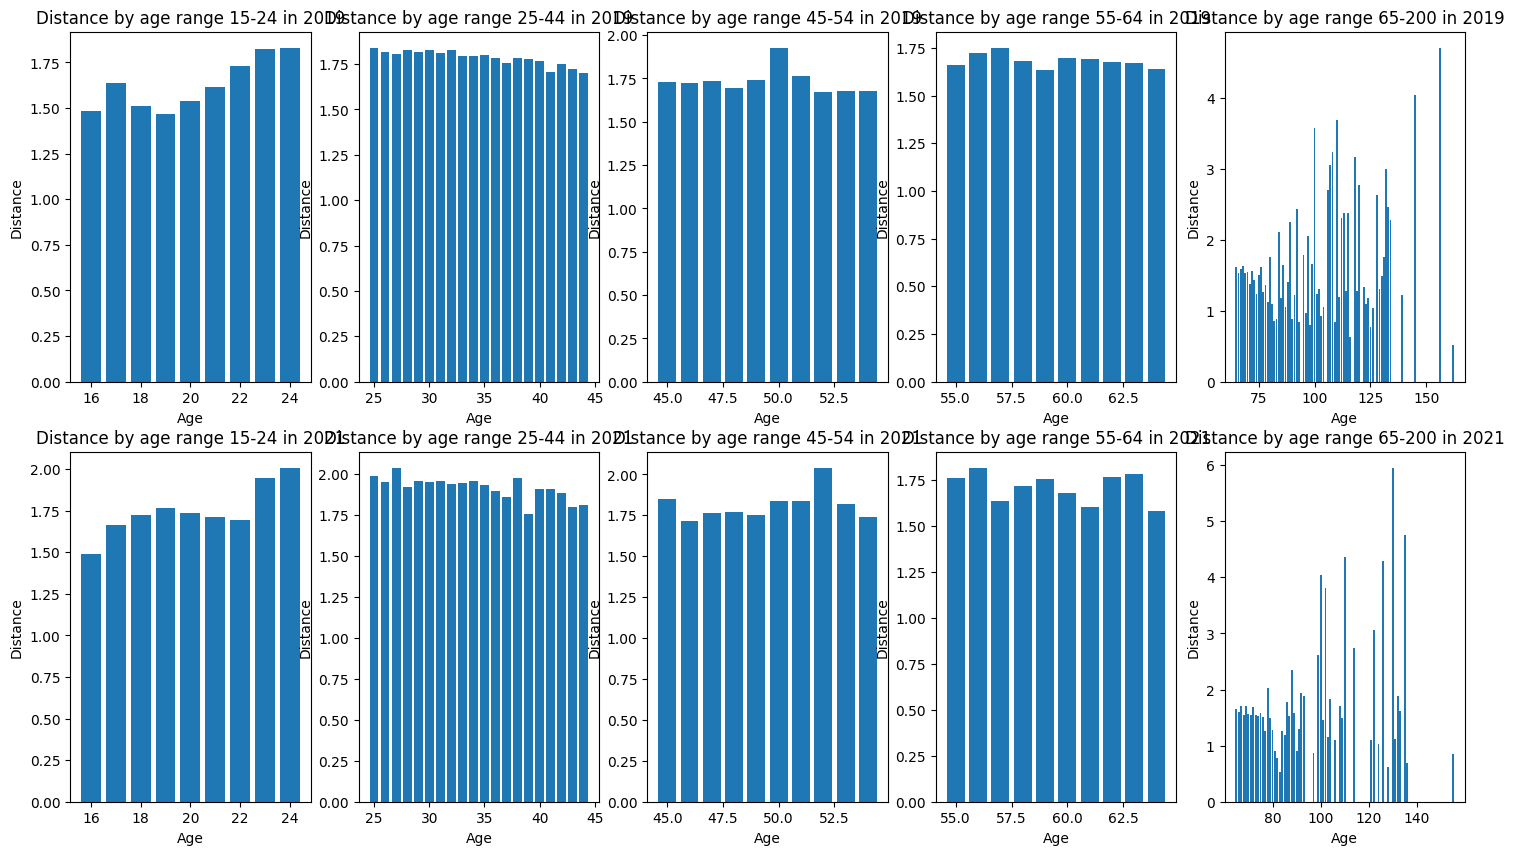

In [15]:
# Trip distance distribution for age ranges
# age is only available for the first schema, where there is "Subscriber"
def cut_to_available_age (df, start_age, end_age):
    df = df.where(col("birth_year").isNotNull())
    df = df.withColumn("age", year("start_time") - col("birth_year"))
    df = df.where(col("age") >= start_age).where(col("age") <= end_age)
    return df

def cut_to_over_age (df, start_age):
    df = df.where(col("birth_year").isNotNull())
    df = df.withColumn("age", year("start_time") - col("birth_year"))
    df = df.where(col("age") >= start_age)
    return df

range_one = (15, 24)
range_two = (25, 44)
range_three = (45, 54)
range_four = (55, 64)
range_five = (65, 200)

dff = replace_lat_long_with_distance(sdf)

def set_axs (axs, range, x, y, year, df):
    axs[x, y].bar(df["age"], df["distance"])
    axs[x, y].set_xlabel('Age')
    axs[x, y].set_ylabel('Distance')
    axs[x, y].set_title(f'Distance by age range {range[0]}-{range[1]} in {year}')
    return axs

def df_range (df, range, y, axs):
    df = cut_to_available_age(dff, range[0], range[1])
    df_2019 = df.where(year("start_time") == 2019).groupBy("age").agg(mean("distance").alias("distance")).toPandas()
    df_2021 = df.where(year("start_time") == 2021).groupBy("age").agg(mean("distance").alias("distance")).toPandas()
    axs = set_axs(axs, range, 0, y, 2019, df_2019)
    axs = set_axs(axs, range, 1, y, 2021, df_2021)
    return axs

figs, axs = plt.subplots(2,5, figsize=(18,10))

axs = df_range(dff, range_one, 0, axs)
axs = df_range(dff, range_two, 1, axs)
axs = df_range(dff, range_three, 2, axs)
axs = df_range(dff, range_four, 3, axs)
axs = df_range(dff, range_five, 4, axs)


plt.show()



### Conclusions for distance distribution by range of age
Overall, everywhere there is an increase in distance for every range of age, but we see a good increase between 15 and 45 and a huge increase for the 65+. (Wrong value because it is unlikely that a 150 year old is doing 4 times as much distance as a 25 year old person)

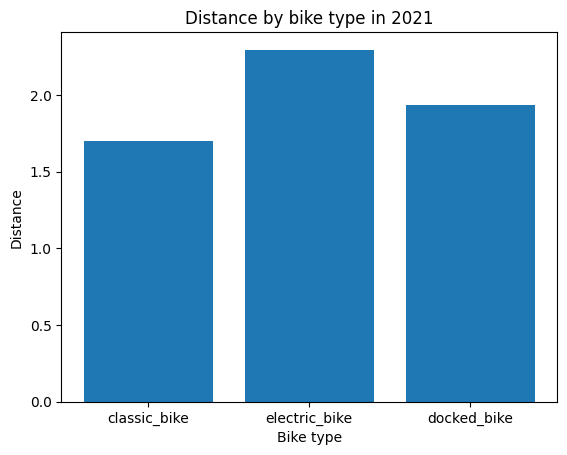

In [16]:
# trip distance distribution for different types of bikes
def cut_to_available_bike (df):
    df = df.where(col("rideable_type") != "Unknown")
    return df

df_bike = replace_lat_long_with_distance(sdf)
df_bike = cut_to_available_bike(df_bike)

bike_pd2019 = df_bike.where(year("start_time") == 2019).groupBy("rideable_type").agg(mean("distance").alias("distance")).toPandas()
bike_pd2021 = df_bike.where(year("start_time") == 2021).groupBy("rideable_type").agg(mean("distance").alias("distance")).toPandas()

figs, axs = plt.subplots()
axs.bar(bike_pd2021["rideable_type"], bike_pd2021["distance"])
axs.set_xlabel('Bike type')
axs.set_ylabel('Distance')
axs.set_title('Distance by bike type in 2021')
plt.show()


### Conclusion to Distance by bike type
obviously, more distance with an electric one
and there is no information on bike types in 2019

## Graph: time series

/tmp/ipykernel_69379/2323862314.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(pd_sdfp["time"], rotation=90)
/tmp/ipykernel_69379/2323862314.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(pd_sdfd["time"], rotation=90)


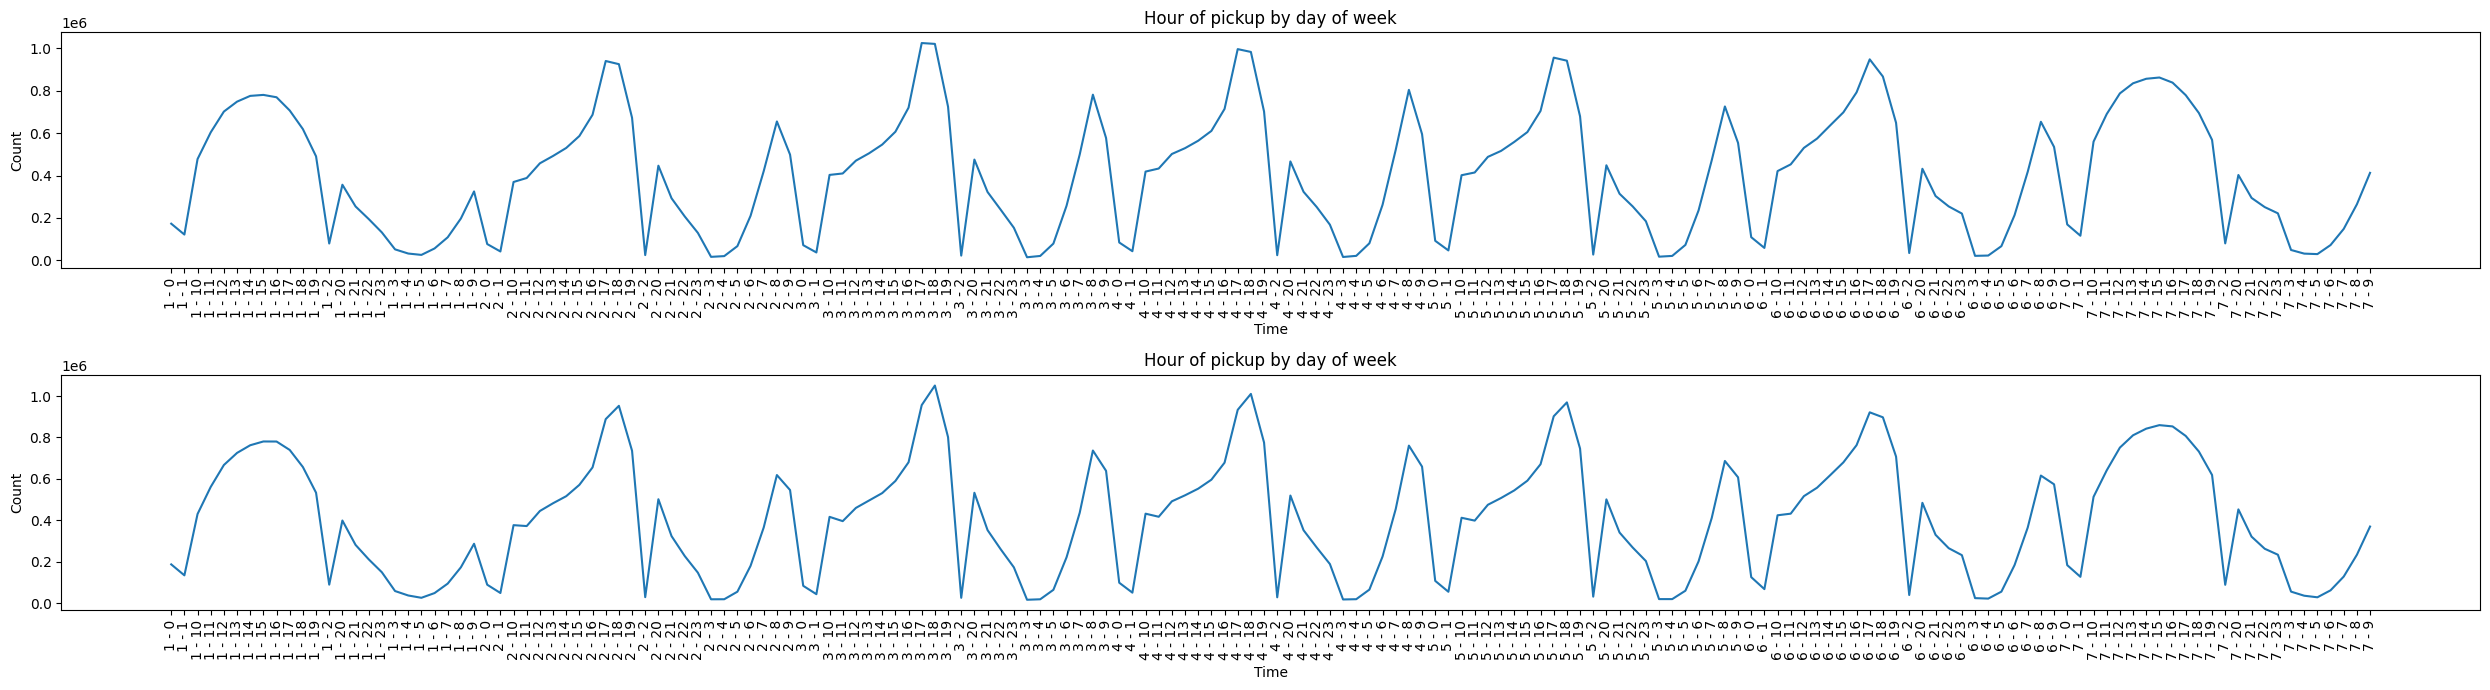

In [17]:
# Number of docks indexed by day of the week and hour of the day

def add_hour_pickup (df):
    df = df.withColumn("hour_pickup", hour(df["start_time"]))
    return df

def add_hour_docks (df):
    df = df.withColumn("hour_docks", hour(df["stop_time"]))
    return df

def add_day_of_week (df):
    df = df.withColumn("day_of_week_pickup", dayofweek(df["start_time"]))
    df = df.withColumn("day_of_week_docks", dayofweek(df["stop_time"]))
    return df

def select_docks (df):
    df = df.select("hour_pickup", "hour_docks" ,"day_of_week_pickup", "day_of_week_docks")
    return df

def cut_days (df, day):
    df = df.where(col("day_of_week") == day)
    return df

#add a column with the count of time an hour is repeated for a day
def count_hour_day (df):
    return df


ssdf = add_hour_docks(sdf)
ssdf = add_hour_pickup(ssdf)
ssdf = add_day_of_week(ssdf)
ssdf = select_docks(ssdf)


ssdf = ssdf.where(col("start_time").isNotNull()).where(col("stop_time").isNotNull())
ssdf_pick = ssdf.select(concat("day_of_week_pickup", lit(" - "), "hour_pickup").alias("time")).groupBy("time").count().orderBy("time")
ssdf_docks = ssdf.select(concat("day_of_week_docks", lit(" - "), "hour_docks").alias("time")).groupBy("time").count().orderBy("time")

pd_sdfp = ssdf_pick.toPandas()
pd_sdfd = ssdf_docks.toPandas()
figs, axs = plt.subplots(2, 1, figsize=(25,7))
axs[0].plot(pd_sdfp["time"], pd_sdfp["count"])
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Count')
axs[0].set_title('Hour of pickup by day of week')
axs[0].set_xticklabels(pd_sdfp["time"], rotation=90)
axs[1].plot(pd_sdfd["time"], pd_sdfd["count"])
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Count')
axs[1].set_title('Hour of pickup by day of week')
axs[1].set_xticklabels(pd_sdfd["time"], rotation=90)
plt.tight_layout()
plt.show()


### Conclusions on number of pickup/docks by day of week and time of day
We have a peak on the weekend on mid day. 
And a peak around 17 during the week, probably for going home after work

/tmp/ipykernel_71564/1242225283.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels(dist_pd["time"], rotation=90)


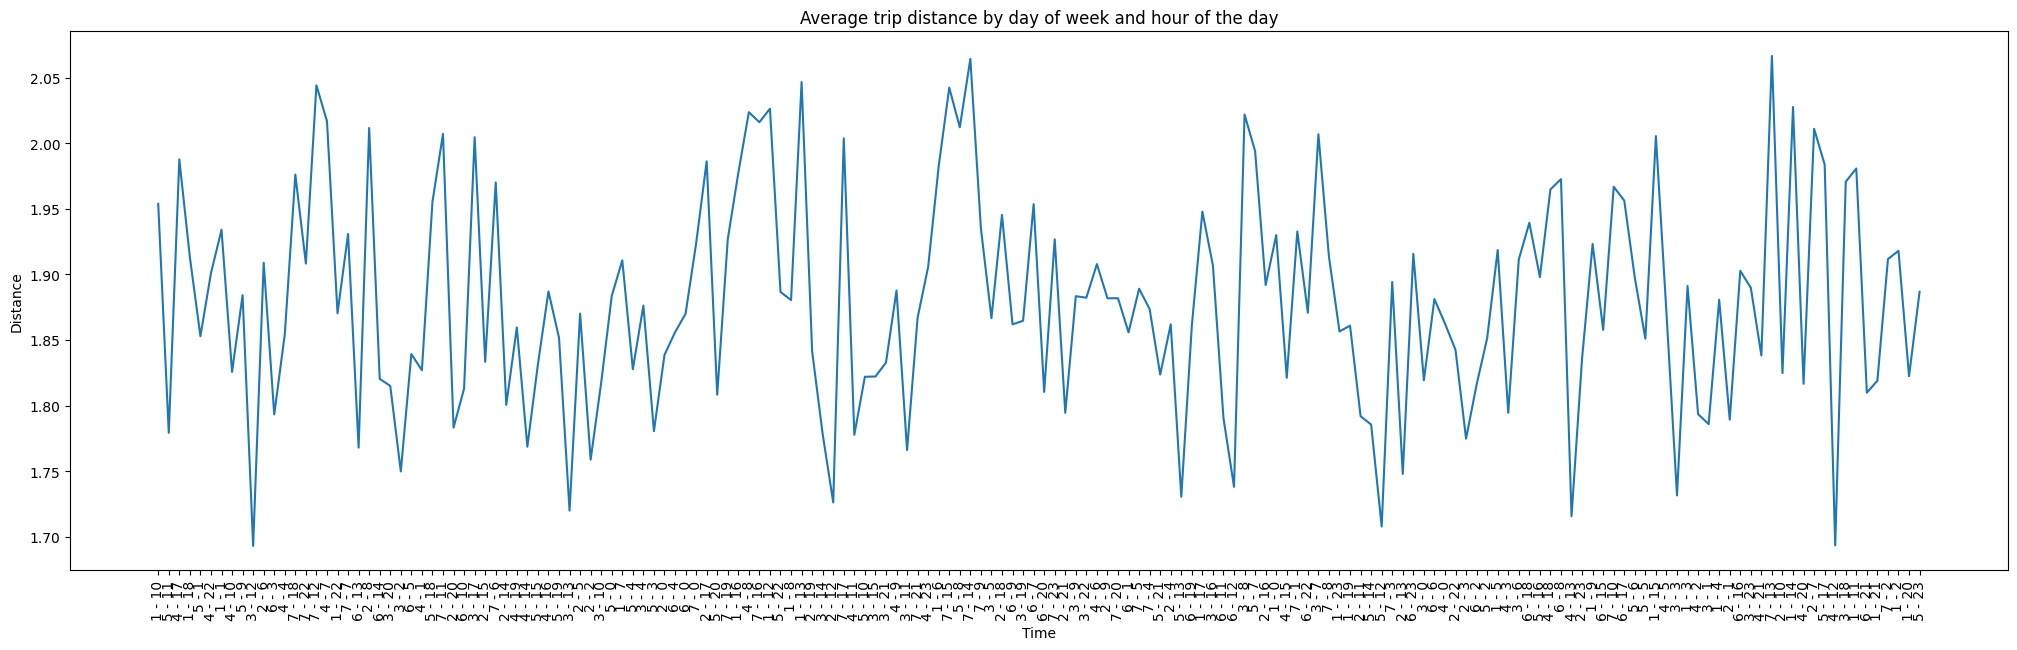

In [12]:
# Average trip distance by day of the week and hour of the day

dist_df = replace_lat_long_with_distance(sdf)
dist_df = dist_df.withColumn("day_of_week", dayofweek(df["start_time"]))
dist_df = dist_df.withColumn("hour", hour(df["start_time"]))
dist_df = dist_df.withColumn("time", concat("day_of_week", lit(" - "), "hour"))
dist_df = dist_df.where(col("time").isNotNull())
dist_df = dist_df.select("time", "distance")

dist_df = dist_df.groupBy("time").agg(mean("distance").alias("distance"))

dist_pd = dist_df.toPandas()
figs, axs = plt.subplots(figsize=(25,7))

axs.plot(dist_pd["time"], dist_pd["distance"])

axs.set_xlabel('Time')
axs.set_ylabel('Distance')
axs.set_title('Average trip distance by day of week and hour of the day')
axs.set_xticklabels(dist_pd["time"], rotation=90)
plt.show()



### Conclusion on average distance indexed by day of the week and time of the day 
We remind that is flight distance, not real distance.
It is pretty inconsistent with no real pattern.

/tmp/ipykernel_71564/3543572212.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels(duration_pd["time"], rotation=90)


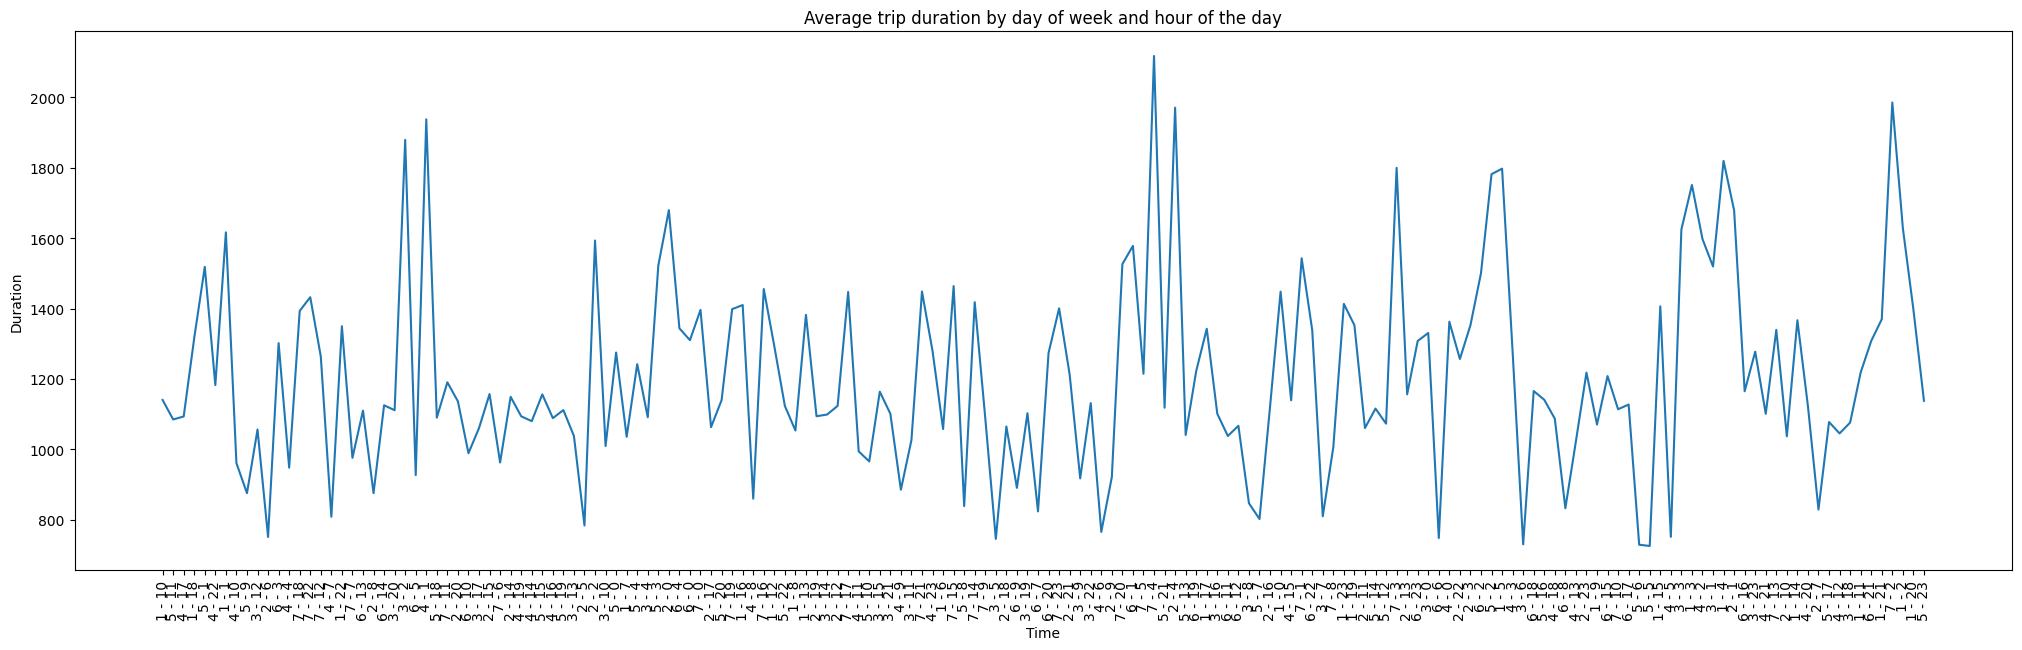

In [13]:
# Average trip duration by day of the week and hour of the day*

duration_df = sdf.withColumn("day_of_week", dayofweek(df["start_time"]))
duration_df = duration_df.withColumn("hour", hour(df["start_time"]))
duration_df = duration_df.withColumn("time", concat("day_of_week", lit(" - "), "hour"))
duration_df = duration_df.where(col("time").isNotNull())
duration_df = duration_df.withColumn("duration", col("stop_time").cast("long") - col("start_time").cast("long"))
duration_df = duration_df.select("time", "duration", "day_of_week")

duration_df = duration_df.groupBy("time").agg(mean("duration").alias("duration"))

duration_pd = duration_df.toPandas()

figs, axs = plt.subplots(figsize=(25,7))
axs.plot(duration_pd["time"], duration_pd["duration"])
axs.set_xlabel('Time')
axs.set_ylabel('Duration')
axs.set_title('Average trip duration by day of week and hour of the day')
axs.set_xticklabels(duration_pd["time"], rotation=90)
plt.show()


### Conclusion on Average duration index by day of the week and time of the day
We see peaks throughout the week, but very late in the day or early in the morning.
People are taking the bicycle when there is less trains or buses